<a href="https://colab.research.google.com/github/cybberowl/pascal_part_MIL/blob/main/pascal_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
colab_path = 'Pascal-part.zip'
local_zip_path = 'data.zip'
data_path = 'Pascal-part'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp '/content/gdrive/My Drive/{colab_path}' {local_zip_path}

In [ ]:
get_ipython().system_raw(f"unzip {local_zip_path}")

In [ ]:
from pathlib import Path
import yaml

In [ ]:
train_labels_path = Path(data_path)/'train_id.txt'
test_labels_path = Path(data_path)/'val_id.txt'
images_path = Path(data_path)/'JPEGImages'
masks_path = Path(data_path)/'gt_masks'
classes_path = Path(data_path)/'classes.txt'

In [ ]:
with open(train_labels_path,'r') as f:
    train_labels = f.read().split('\n')

with open(test_labels_path,'r') as f:
    test_labels = f.read().split('\n')

with open(classes_path,'r') as f:
    classes_signature = yaml.safe_load(f)

In [ ]:
classes_signature

{0: 'bg',
 1: 'low_hand',
 2: 'torso',
 3: 'low_leg',
 4: 'head',
 5: 'up_leg',
 6: 'up_hand'}

```
├── (0) background
└── body
    ├── upper_body
    |   ├── (1) low_hand
    |   ├── (6) up_hand
    |   ├── (2) torso
    |   └── (4) head
    └── lower_body
        ├── (3) low_leg
        └── (5) up_leg
```

In [ ]:
classes_hierarchy = {
    'bg':0,
    'body':{
        'upper_body': {
            'low_hand' : 1,
            'up_hand' : 6,
            'torso' : 2,
            'head' : 4
        },
        'lower_body': {
            'low_leg': 3,
            'up_leg' : 5
        }
    }
    }

In [ ]:
import numpy as np

def flatten_nested_dict(input_d, output_d):
    ### return all values of subdictionaries
    res_dict = {}
    values = []
    for k,v in input_d.items():
        if not isinstance(v,dict):
            output_d[k] = [v]
            values.append(v)
        else:
            sub_values = flatten_nested_dict(v, output_d)
            output_d[k] = sub_values
            values = values + sub_values

    return values

def depth_of_keys(d):

    res = {}

    for k,v in d.items():
        res[k] = 1
        if isinstance(v,dict):
            sub_depth = depth_of_keys(v)
            for subk,subv in sub_depth.items():
                res[subk] = subv + 1

    return res

def make_classes_mapping(classes_hierarchy, exclude_keys):

    assert(isinstance(exclude_keys,list))

    values_dict = {}
    flatten_nested_dict(classes_hierarchy, values_dict)
    depth = depth_of_keys(classes_hierarchy)

    class_content = {}

    for k in values_dict:
        dep_k = depth[k]
        if f'level_{dep_k}' not in class_content:
            class_content[f'level_{dep_k}'] = {}
        if k not in exclude_keys:
            class_content[f'level_{dep_k}'][k] = values_dict[k]

    return class_content


In [ ]:
class_content = make_classes_mapping(classes_hierarchy, ['bg'])

In [ ]:
class_content

{'level_1': {'body': [1, 6, 2, 4, 3, 5]},
 'level_3': {'low_hand': [1],
  'up_hand': [6],
  'torso': [2],
  'head': [4],
  'low_leg': [3],
  'up_leg': [5]},
 'level_2': {'upper_body': [1, 6, 2, 4], 'lower_body': [3, 5]}}

In [ ]:
N_LEVELS = 3
N_CLASSES = 7

In [ ]:
import torch
def decompose_mask(mask:torch.Tensor,class_content):
    '''
    convert one mask to N_LEVELS masks
    mask in tensor BS x H x W
    '''
    assert(mask.ndim == 3)
    res = []
    for level in sorted(class_content,key = lambda x: int(x.split('_')[1])):
        new_mask = mask.clone().to(device)
        counter = 1
        for key, classes in class_content[level].items():
            ### counter is label for new class on mid levels
            ### for lowest level (classes is singleton list) we use original labels
            ### bg class always remains 0 on every level
            new_mask[torch.isin(mask,torch.Tensor(classes).to(device))] = counter if len(classes) > 1 else classes[0]
            counter += 1
        res.append(new_mask)
    return res

In [ ]:
def aggregate_probs(probs: torch.Tensor, class_content, bg_class = 0):
    '''
    aggregate low-level probabilities to N_LEVELS probabilities of higher classes
    probs is tensor BS x C x H x W
    '''
    res = []
    for level in sorted(class_content,key = lambda x: int(x.split('_')[1])):

        shape = list(probs.shape)
        shape[1] = len(class_content[level]) + 1 ### extra size for bg class
        new_probs = torch.zeros(size = shape, dtype = torch.float32).to(device)
        idx = 0
        new_probs[:,idx,...] = probs[:,bg_class,...] ### here we use it
        for key, classes in class_content[level].items():
            idx += 1
            for c in classes:
                new_probs[:,idx,...] += probs[:,c,...]
        res.append(new_probs)
    return res

In [ ]:
import torch
import numpy as np

class HierarchicalMIoU:

    def __init__(self, class_content, smooth = 1e-8):
        self.class_content = class_content
        self.smooth = smooth
        self.n_levels = len(class_content)

    def iou(self, outputs : np.array, labels: np.array):

        #inputs are boolean BS x W x H arrays

        assert(isinstance(outputs,np.ndarray))
        assert(isinstance(labels,np.ndarray))
        assert(outputs.ndim == 3)
        assert(labels.ndim == 3)
        assert(outputs.dtype == np.bool_)
        assert(labels.dtype == np.bool_)

        num = (outputs & labels).sum((1,2)) ### sum over BS x W x H
        denum = (outputs | labels).sum((1,2)) ### sum over BS x W x H
        metric = (num+self.smooth) / (denum + self.smooth) ### smooth for numerical stability
        metric = metric.mean() ### mean value over batch

        return metric.item()

    def __call__(self, outputs: list, labels: torch.Tensor):

        ### outputs is list of N_LEVELS tensors of shape BS x H x W
        ### labels is tensor of shape BS x H x W

        assert (len(outputs) == self.n_levels)
        labels = decompose_mask(labels,self.class_content)
        ### now labels is list of  N_LEVELS tensors of shape BS x H x W

        error = {}

        for i in range(self.n_levels):
            level = f'level_{i+1}'
            error[level] = 0.0
            for j,key in enumerate(self.class_content[level]):
                metric = self.iou((outputs[i].to('cpu').numpy()==j),(labels[i].to('cpu').numpy() == j))
                error[level+'_'+key] = metric
                error[level] += metric
            error[level] /= len(self.class_content[level])

        return error

In [ ]:
import torch.nn.functional as F

class SimpleHierarchicalClassSelector:

    def __init__(self, class_content):

        self.class_content = class_content

    def __call__(self, x_batch):

        ### x_batch is BS x C x H x W

        prob = F.softmax(x_batch, dim = 1) # BS x C x H x W -> BS x C x H x W
        labels = torch.argmax(prob, dim = 1) # BS x C x H x W -> BS x H x W

        res = decompose_mask(labels, self.class_content) # BS x H x W  -> list of BS x H x W
        return res

class SmartHierarchicalClassSelector:

    def __init__(self, class_content):

        self.class_content = class_content

    def __call__(self, x_batch):

        ### x_batch is BS x C x H x W

        prob = F.softmax(x_batch, dim = 1)  # BS x C x H x W -> BS x C x H x W
        prob_array = aggregate_probs(prob,self.class_content) # BS x C x H x W -> list of N_LEVELS tensors BS x C x H x W
        labels = [torch.argmax(p,dim = 1) for p in prob_array]

        return labels

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from PIL.Image import BILINEAR, LANCZOS
import cv2
import albumentations as A

class SegDataset(Dataset):

    def __init__(self,images_path, masks_path, labels, size, transform = None,
                 resample = BILINEAR):

        '''
        pass masks_path = None to return only x_batch
        '''
        super().__init__()
        self.images_path = Path(images_path)
        self.masks_path = Path(masks_path) if masks_path else None
        self.names = labels
        self.transform = transform
        self.size = size
        self.max_pixel_value = 255
        self.resample = resample

    def get_image_path(self,i):

        return self.images_path/f"{self.names[i]}.jpg"

    def get_mask_path(self, i):

        return self.masks_path/f"{self.names[i]}.npy"

    def load_image_and_mask(self,i):
        image_path = self.get_image_path(i)
        image = Image.open(image_path)
        image = image.resize(self.size, resample = self.resample)

        if self.masks_path:
            mask_path = self.get_mask_path(i)
            mask = np.load(mask_path)
            mask = cv2.resize(mask, self.size) ### no new classes after resize with default interpolation

            return np.array(image), mask

        else:
            return np.array(image)

    def __getitem__(self, i):

        item = self.load_image_and_mask(i)
        image, mask = item if self.masks_path else (item,None)
        if self.transform: ### augmentation from albumentation, which transforms both image and mask

            if self.masks_path:
                aug_pair = self.transform(image = image, mask = mask)
                image = aug_pair['image']
                mask = aug_pair['mask']
            else:
                aug_pair = self.transform(image = image)
                image = aug_pair['image']

        image = image / self.max_pixel_value
        image = np.transpose(image, (2,0,1)) ### H x W x C -> C x H x W

        if self.masks_path:
            return image.astype(np.float32), mask.astype(np.int64)

        else:
            return image.astype(np.float32)

    def __len__(self):
        return len(self.names)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

size = (256,256)
test_size = 0.25
batch_size = 16

num_workers = 8
prefetch_factor = 3

# rng = torch.Generator()
# rng.manual_seed(0)

train_l, val_l = train_test_split(train_labels, test_size = test_size, random_state = 0)

train_ds = SegDataset(images_path, masks_path, train_l, size, transform = None,
                 resample = BILINEAR)
train_gen = DataLoader(train_ds,batch_size = batch_size, shuffle = True,
                       num_workers = num_workers, prefetch_factor = prefetch_factor)

val_ds = SegDataset(images_path, masks_path, val_l, size, transform = None,
                 resample = BILINEAR)
val_gen = DataLoader(val_ds,batch_size = batch_size, shuffle = False,
                       num_workers = num_workers, prefetch_factor = prefetch_factor)

print(len(train_gen))
print(len(val_gen))

cuda
133
45


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams["figure.figsize"] = (12,12)

def plot_examples(X,Y, k = 5, class_content = None, decomposed = False):
    # X and Y are batches from data gen BS x C x H x W
    rows = 2
    if decomposed:
        Y_list = decompose_mask(Y,class_content)
        rows = rows + len(Y_list) - 1
    for i in range(k):
        plt.subplot(rows, k, i+1)
        plt.axis("off")
        plt.imshow(X[i].to('cpu').permute((1,2,0))) ### C x H x W -> H x W x C
        plt.title('Image')

        if decomposed:
            for j,Y_ in enumerate(Y_list):
                plt.subplot(rows, k, i+k+j*k+1)
                plt.axis("off")
                plt.imshow(Y_[i].to('cpu'), cmap = 'jet')
                plt.title(f'Mask level {j+1}')
        else:
            plt.subplot(rows, k, i+k+1)
            plt.axis("off")
            plt.imshow(Y[i], cmap = 'jet')
            plt.title('Mask')

    plt.show();

In [ ]:
# plt.figure(figsize = (12,12))
# X,Y = iter(train_gen).__next__()
# X,Y = X.to(device), Y.to(device)
# plot_examples(X,Y, class_content = class_content, decomposed = True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

def create_convolution_block(in_channels, out_channels, kernel_size, block_depth,
        enable_batchnorm, act_class, change_channels = 'first'):

    res = nn.Sequential()
    cin = in_channels
    cout = in_channels

    assert(change_channels in ['first','last']) # first for encoder and last for decoder

    index_change_channels = 0 if change_channels == 'first' else block_depth-1

    for i in range(block_depth):
        if i == index_change_channels:
            cout = out_channels
        layer = nn.Sequential()
        layer.add_module(f'conv', nn.Conv2d(in_channels = cin,out_channels = cout,
                            kernel_size = kernel_size, padding = 'same'))
        cin = cout

        if enable_batchnorm:
            layer.add_module(f'batchnorm',nn.BatchNorm2d(num_features=cout))

        layer.add_module(f'activation', act_class())
        res.add_module(f'conv_layer_{i}', layer)

    return res

class SegNetEncoder(nn.Module):

    def __init__(self,
                in_channels,
                channels_array,
                pool_kernel_size,
                conv_kernel_size,
                block_depth,
                enable_batchnorm,
                act_class):

        super().__init__()
        self.conv_blocks = nn.ModuleList()
        self.poolings = nn.ModuleList()

        for i, channels in enumerate(channels_array):
            conv_block = create_convolution_block(in_channels,channels, pool_kernel_size,
                    block_depth, enable_batchnorm, act_class, change_channels='first')
            pooling = nn.MaxPool2d(kernel_size=pool_kernel_size,return_indices=True)
            self.conv_blocks.append(conv_block)
            self.poolings.append(pooling)
            in_channels = channels

    def forward(self, x):

        pool_idx_array = []
        for conv_block, pooling in zip(self.conv_blocks, self.poolings):
            x = conv_block(x)
            x, idx = pooling(x)
            pool_idx_array.append(idx)

        return x, pool_idx_array

class SegNetDecoder(nn.Module):

    def __init__(self,
                in_channels,
                out_channels,
                inv_channels_array,
                pool_kernel_size,
                conv_kernel_size,
                block_depth,
                enable_batchnorm,
                act_class):

        super().__init__()
        self.conv_blocks = nn.ModuleList()
        self.poolings = nn.ModuleList()

        for i, channels in enumerate(inv_channels_array):

            conv_block = create_convolution_block(in_channels,channels, conv_kernel_size,
                    block_depth, enable_batchnorm, act_class, change_channels='last')
            unpooling = nn.MaxUnpool2d(kernel_size=pool_kernel_size)
            self.conv_blocks.append(conv_block)
            self.poolings.append(unpooling)
            in_channels = channels

        self.last_layer = nn.Conv2d(in_channels = in_channels,
                                    out_channels=out_channels,
                                    kernel_size=1,
                                    padding = 'same')

    def forward(self, x, inv_pool_idx_array):

        for conv_block, unpooling, idx in zip(self.conv_blocks, self.poolings, inv_pool_idx_array):
            x = unpooling(x, idx)
            x = conv_block(x)

        x = self.last_layer(x)

        return x

class SegNet(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 encoder_channels_array,
                 decoder_channels_array,
                 pool_kernel_size = 2,
                 conv_kernel_size = 5,
                 block_depth = 3,
                 enable_batchnorm = True,
                 act_class = nn.ReLU):
        super().__init__()

        assert len(encoder_channels_array) == len(decoder_channels_array)
        assert np.allclose(encoder_channels_array[:-1],decoder_channels_array[:-1][::-1])

        self.Encoder = SegNetEncoder(in_channels,
                                     encoder_channels_array,
                                     pool_kernel_size,
                                     conv_kernel_size,
                                     block_depth,
                                     enable_batchnorm,
                                     act_class)

        self.bottleneck_conv = create_convolution_block(in_channels=encoder_channels_array[-1],
                                                        out_channels=encoder_channels_array[-1],
                                                        kernel_size=conv_kernel_size,
                                                        block_depth = block_depth,
                                                        enable_batchnorm = enable_batchnorm,
                                                        act_class = act_class)


        self.Decoder = SegNetDecoder(encoder_channels_array[-1],
                                     out_channels,
                                     decoder_channels_array,
                                     pool_kernel_size,
                                     conv_kernel_size,
                                     block_depth,
                                     enable_batchnorm,
                                     act_class)

    def forward(self, x):

        # encoder
        e, pool_idx_array = self.Encoder(x)
        inv_pool_idx_array = pool_idx_array[::-1]

        # bottleneck
        b = self.bottleneck_conv(e)

        # decoder
        d = self.Decoder(b,inv_pool_idx_array)
        return d

In [ ]:
model = SegNet(in_channels=3,
               out_channels=N_CLASSES,
               encoder_channels_array = [64,128,256, 512],
               decoder_channels_array = [256, 128, 64, 64],
               pool_kernel_size = 2,
               conv_kernel_size = 5,
               block_depth = 3,
               enable_batchnorm = True,
               act_class = nn.ReLU).to(device)

In [ ]:
# Y_pred = model(X)

In [ ]:
simple_class_selector = SimpleHierarchicalClassSelector(class_content)
smart_class_selector = SmartHierarchicalClassSelector(class_content)
metric = HierarchicalMIoU(class_content)

In [ ]:
# metric(simple_class_selector(Y_pred),Y)

In [ ]:
# metric(smart_class_selector(Y_pred),Y)

In [ ]:
def plot_examples_learing(X,true_mask, predicted_masks, k = 3, class_content = None, decomposed = False):
    # X is batch from data gen BS x C x H x W
    # true_mask is batch from data gen BS x 1 x H x W
    # predicted_masks is list of N_LEVELS tensors BS x 1 x H x W
    rows = k
    cols = 3
    if decomposed:
        Y_list = decompose_mask(true_mask,class_content)
        cols = cols + 2*len(Y_list) - 2
    for i in range(k):
        plt.subplot(rows, cols, i*cols+1)
        plt.axis("off")
        plt.imshow(X[i].to('cpu').permute((1,2,0))) ### C x H x W -> H x W x C
        plt.title(f'Image #{i}')

        if decomposed:
            for j,Y_ in enumerate(Y_list):
                plt.subplot(rows, cols, i*cols+2+j)
                plt.axis("off")
                plt.imshow(Y_[i].to('cpu'), cmap = 'jet')
                plt.title(f'True L{j+1} #{i}')

                plt.subplot(rows, cols, i*cols+2+j + len(Y_list))
                plt.axis("off")
                plt.imshow(predicted_masks[j][i].to('cpu'), cmap = 'jet')
                plt.title(f'Predicted L{j+1} #{i}')
        else:
            plt.subplot(rows, cols, i*cols+2)
            plt.axis("off")
            plt.imshow(true_mask[i].to('cpu'), cmap = 'jet')
            plt.title(f'True #{i}')

            plt.subplot(rows, cols, i*cols+3)
            plt.axis("off")
            plt.imshow(predicted_masks[-1][i].to('cpu'), cmap = 'jet')
            plt.title(f'Predicted #{i}')

    plt.tight_layout()
    plt.show();

In [ ]:
# plot_examples_learing(X,Y, simple_class_selector(Y_pred), decomposed=True, class_content = class_content)

In [ ]:
# plot_examples_learing(X,Y, smart_class_selector(Y_pred), decomposed=True, class_content = class_content)

In [ ]:
def score_model(model, class_selector, metric, data):

    model.eval()  # testing mode
    scores = {'mean':{},'std':{}}

    ### compute sum and sum of squares in online manner

    for X_batch, Y_label in tqdm(data):

        Y_pred = class_selector(model(X_batch.to(device))) ### list of BS x 1 x H x W masks
        metric_dict = metric(Y_pred, Y_label.to(device))

        for key, val in metric_dict.items():

            if key not in scores['mean']:
                scores['mean'][key] = 0.0

            scores['mean'][key] += val

            if key not in scores['std']:
                scores['std'][key] = 0.0

            scores['std'][key] += val**2

    ### now convert sum and sum squared to mean and std

    for key in scores['mean']:
        scores['mean'][key] = scores['mean'][key]/len(data)

    for key in scores['std']:
        scores['std'][key] = scores['std'][key]/len(data) - scores['mean'][key]**2 ## variance of metric on batch
        scores['std'][key] = scores['std'][key] / len(data) ## variance of mean estimate
        scores['std'][key] = np.sqrt(scores['std'][key]) ### std

    return scores

In [ ]:

from tqdm.notebook import tqdm

def train(model, opt, loss_fn, class_selector, class_content, epochs, data_tr, data_val):

    train_loss = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0.0
        model.train()  # train mode

        for X_batch, Y_batch in tqdm(data_tr):

            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred,Y_batch)
            loss.backward()

            opt.step()

            # calculate loss
            avg_loss += loss.detach().to('cpu').numpy() / len(data_tr)

        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)

        model.eval() # testing mode

        X_val, Y_val = next(iter(data_val))
        X_val, Y_val = X_val.to(device).detach(), Y_val.to(device).detach()
        Y_hat = class_selector(model(X_val))

        clear_output(wait=True)
        plot_examples_learing(X_val,Y_val, Y_hat, decomposed=True, class_content = class_content)

        print('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))


        # avg_loss = 0.0
        # for X_batch, Y_batch in data_val:
        #     # data to device
        #     X_batch, Y_batch = X_batch.to(device).detach(), Y_batch.to(device).detach()
        #     Y_pred = model(X_batch)
        #     loss = loss_fn(Y_pred,Y_batch)
        #     avg_loss += loss.detach().to('cpu').numpy() / len(data_val)
        # val_loss.append(avg_loss)

    return train_loss

In [ ]:
def plot_loss(train_loss, val_loss):

    plt.plot(train_loss, label = 'train')
    plt.plot(val_loss, label = 'val')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.show()

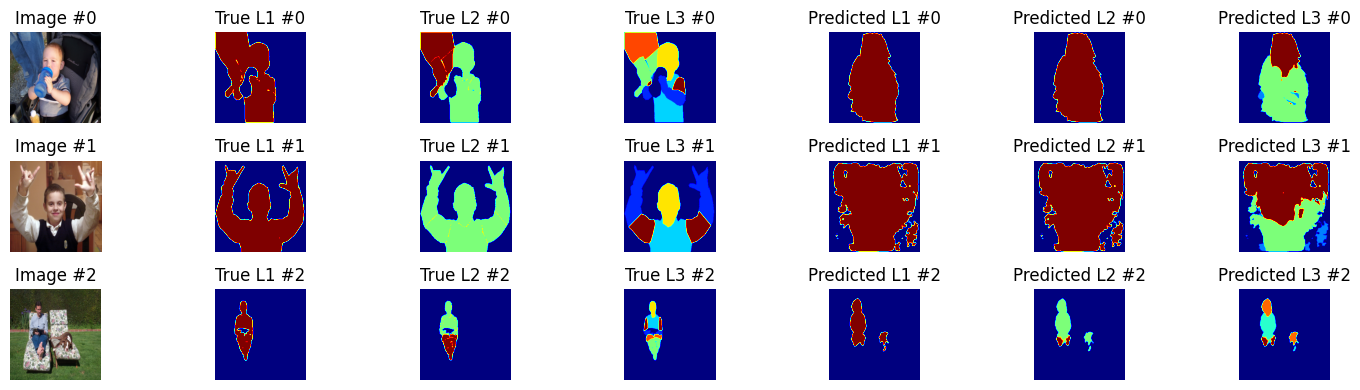

7 / 20 - loss: 0.605948
* Epoch 8/20


  0%|          | 0/133 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
lr = 1e-3
max_epochs = 20
bce_loss = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr = lr)
train_loss = train(model = model,
                opt = opt,
                loss_fn = bce_loss,
                class_selector = simple_class_selector,
                class_content = class_content,
                epochs = max_epochs,
                data_tr = train_gen,
                data_val = val_gen)

In [ ]:
plot_loss(train_loss, val_loss)

NameError: name 'train_loss' is not defined

In [ ]:
score_model(model, simple_class_selector, metric, val_gen)

  0%|          | 0/45 [00:00<?, ?it/s]

{'mean': {'level_1': 0.793625145726113,
  'level_1_body': 0.793625145726113,
  'level_2': 0.5450129364596882,
  'level_2_upper_body': 0.793625145726113,
  'level_2_lower_body': 0.29640072719326316,
  'level_3': 0.2152557288132467,
  'level_3_low_hand': 0.793625145726113,
  'level_3_up_hand': 0.03299894840175981,
  'level_3_torso': 0.16543254145962547,
  'level_3_head': 0.0041666668251474585,
  'level_3_low_leg': 0.2409924381343951,
  'level_3_up_leg': 0.05431863233243943},
 'std': {'level_1': 0.0063387961347525276,
  'level_1_body': 0.0063387961347525276,
  'level_2': 0.004358634926893703,
  'level_2_upper_body': 0.0063387961347525276,
  'level_2_lower_body': 0.007841873150936856,
  'level_3': 0.0027466586043454412,
  'level_3_low_hand': 0.0063387961347525276,
  'level_3_up_hand': 0.0026771828180282143,
  'level_3_torso': 0.005851261992880673,
  'level_3_head': 0.0023240556248149526,
  'level_3_low_leg': 0.008562113236643314,
  'level_3_up_leg': 0.008393724029307456}}

In [ ]:
score_model(model, smart_class_selector, metric, val_gen)

  0%|          | 0/45 [00:00<?, ?it/s]

{'mean': {'level_1': 0.7556213333294186,
  'level_1_body': 0.7556213333294186,
  'level_2': 0.5370886453480931,
  'level_2_upper_body': 0.7650491019071831,
  'level_2_lower_body': 0.3091281887890031,
  'level_3': 0.18978320517857172,
  'level_3_low_hand': 0.793625145726113,
  'level_3_up_hand': 0.03299894840175981,
  'level_3_torso': 0.0027918428992992164,
  'level_3_head': 0.018290855724689824,
  'level_3_low_leg': 0.2409924381343951,
  'level_3_up_leg': 0.05000000018517315},
 'std': {'level_1': 0.008024902301908051,
  'level_1_body': 0.008024902301908051,
  'level_2': 0.004863109777387757,
  'level_2_upper_body': 0.007650291445980943,
  'level_2_lower_body': 0.007503996449185515,
  'level_3': 0.0023450788341608693,
  'level_3_low_hand': 0.0063387961347525276,
  'level_3_up_hand': 0.0026771828180282143,
  'level_3_torso': 0.0019196260827500254,
  'level_3_head': 0.0020757018058448584,
  'level_3_low_leg': 0.008562113236643314,
  'level_3_up_leg': 0.008240220542158692}}

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git --set-upstream https://github.com/cybberowl/pascal_part_MIL.git

unknown option: --set-upstream
usage: git [--version] [--help] [-C <path>] [-c <name>=<value>]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | -P | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           [--super-prefix=<path>] [--config-env=<name>=<envvar>]
           <command> [<args>]
